<a href="https://colab.research.google.com/github/Saucymukhim/New/blob/main/SAUCYMUKHIM20MARCH_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Environment Setup & Installation**

*mount the drive and install necessary libraries.*

In [ ]:
# CELL 1: Mount Drive and Install Packages

from google.colab import drive
from IPython.display import display, HTML

def card(msg, bg):
    display(HTML(f"<div style='background:{bg};padding:14px;border-radius:10px;"
                 "color:white;font-family:Segoe UI;box-shadow:0 4px 14px #0005'>"
                 f"<b>{msg}</b></div>"))

card(" Connecting to Google Drive…", "linear-gradient(135deg,#232526,#414345)")
drive.mount("/content/drive")
card(" Drive mounted at /content/drive", "linear-gradient(135deg,#11998e,#38ef7d)")

path = "/content/drive/MyDrive/SaucyDataset"

display(HTML(f"<div style='background:linear-gradient(135deg,#141e30,#243b55);"
             "padding:14px;border-radius:10px;color:white;"
             "font-family:Segoe UI;box-shadow:0 4px 14px #0005'>"
             f"<b>📁 Dataset directory</b><br><code>{path}</code></div>"))

%cd {path}

# Install required packages for the environment
!pip uninstall torch torchvision torchaudio -y
!pip install torch torchvision torchaudio --no-cache-dir
!pip install --upgrade -q timm scikit-learn seaborn rich
!pip install grad-cam
!pip install optuna
!pip install pytorch-grad-cam
!pip install albumentations
!pip install torchmetrics
!pip install opencv-python

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/content/drive/MyDrive/SaucyDataset
Found existing installation: torch 2.10.0
Uninstalling torch-2.10.0:
  Successfully uninstalled torch-2.10.0
Found existing installation: torchvision 0.25.0
Uninstalling torchvision-0.25.0:
  Successfully uninstalled torchvision-0.25.0
Found existing installation: torchaudio 2.10.0
Uninstalling torchaudio-2.10.0:
  Successfully uninstalled torchaudio-2.10.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.7/915.7 MB 139.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 167.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 235.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.8.6 requires torch<2.10,>=1.10, but you have torch 2.10.0 which is incompatible.
ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)


# **Imports & Configuration**

*Import libraries and define the central configuration class.*

In [ ]:
# CELL 2: Imports and Configuration

import os, json, random, warnings
import torch, torch.nn as nn, torch.optim as optim, torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import datasets, transforms
import timm, cv2, optuna
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, precision_recall_fscore_support
from sklearn.model_selection import StratifiedKFold
from torchmetrics import CalibrationError
from tqdm import tqdm
from datetime import datetime

warnings.filterwarnings("ignore")

from IPython.display import display, HTML
display(HTML("<div style='background:#020617;padding:10px;border-radius:8px;"
             "color:#86efac;font-family:Segoe UI'>"
             "📦 <b>Libraries imported successfully</b> — system ready</div>"))

# Central configuration class
class Config:
    """Configuration class for the bone fracture detection project."""

    def __init__(self):
        self.DATA_PATH = "/content/drive/MyDrive/SaucyDataset"
        self.OUTPUT_DIR = "/content/drive/MyDrive/SaucyDataset_Output"
        os.makedirs(self.OUTPUT_DIR, exist_ok=True)

        self.MODEL_NAME = 'tf_efficientnetv2_s.in1k'
        self.IMAGE_SIZE = 256
        self.BATCH_SIZE = 8
        self.EPOCHS = 30
        self.LEARNING_RATE = 1e-4
        self.NUM_CLASSES = 2

        self.D_MODEL = 256
        self.NHEAD = 8
        self.NUM_ENCODER_LAYERS = 4
        self.DIM_FEEDFORWARD = 2048
        self.DROPOUT = 0.1

        self.K_FOLDS = 2
        self.SEED = 42

        # Weakly supervised segmentation settings
        self.RUN_WEAK_SEG = False
        self.SEG_EPOCHS = 5
        self.SEG_LEARNING_RATE = 1e-4
        self.SEG_THRESHOLD = 0.5

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


CFG = Config()

from IPython.display import display, HTML
display(HTML(f"<div style='background:#020617;padding:10px;border-radius:8px;"
             "color:#93c5fd;font-family:Segoe UI'>"
             f"⚙️ <b>Config loaded</b> | Device: <code>{CFG.device}</code></div>"))

# **Data Handling**

*Classes for handling data transforms and dataset loading.*

In [ ]:
# CELL 3: Data Handling & Transforms

class DataTransforms:
    """Class to handle data transformations for different phases (train, val, test, tta)."""

    @staticmethod
    def get_transforms(image_size, phase='train'):
        if phase == 'train':
            return transforms.Compose([
                transforms.RandomResizedCrop(image_size),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(10),
                transforms.ColorJitter(0.2, 0.2, 0.2, 0.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
            ])
        elif phase in ['val', 'test']:
            return transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406],
                                     [0.229, 0.224, 0.225])
            ])
        elif phase == 'tta':
            return [
                transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(image_size),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])
                ]),
                transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(image_size),
                    transforms.RandomHorizontalFlip(1.0),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])
                ]),
                transforms.Compose([
                    transforms.Resize(256),
                    transforms.CenterCrop(image_size),
                    transforms.RandomRotation(10),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406],
                                         [0.229, 0.224, 0.225])
                ])
            ]
        else:
            raise ValueError(f"Unknown phase: {phase}")


class DatasetManager:
    """Class to handle dataset loading, splits, and dataloaders."""

    @staticmethod
    def load_dataset(data_path):
        if not os.path.exists(data_path):
            raise FileNotFoundError(f"Data path not found: {data_path}")
        return data_path

    @staticmethod
    def create_dataset_splits(data_path, image_size):
        tfms = {
            'train': DataTransforms.get_transforms(image_size, 'train'),
            'val': DataTransforms.get_transforms(image_size, 'val'),
            'test': DataTransforms.get_transforms(image_size, 'test')
        }
        return {k: datasets.ImageFolder(os.path.join(data_path, k), tfms[k])
                for k in ['train', 'val', 'test']}

    @staticmethod
    def create_dataloaders(image_datasets, batch_size):
        loaders = {k: DataLoader(image_datasets[k], batch_size,
                                 shuffle=(k == 'train'), num_workers=2)
                   for k in ['train', 'val', 'test']}
        sizes = {k: len(image_datasets[k]) for k in loaders}
        classes = image_datasets['train'].classes
        return loaders, sizes, classes

    @staticmethod
    def prepare_metadata(image_datasets):
        meta = {}
        for split, ds in image_datasets.items():
            meta[split] = [
                {
                    'filepath': p,
                    'filename': os.path.basename(p),
                    'label': y,
                    'class_name': c,
                    'site_id': f"site_{random.randint(1,5)}"
                }
                for p, y in ds.samples
                for c, i in ds.class_to_idx.items() if i == y
            ]
        path = os.path.join(CFG.OUTPUT_DIR, "metadata.json")
        json.dump(meta, open(path, "w"), indent=2)
        return meta

from IPython.display import display, HTML
display(HTML("<div style='background:#020617;padding:10px;border-radius:8px;"
             "color:#a5b4fc;font-family:Segoe UI'>"
             " <b>Data handling & transforms ready</b></div>"))

# **Model Architecture**

*Definition of the Hybrid CNN-Transformer model.*

In [ ]:
# CELL 4: Hybrid CNN-Transformer Model

class HybridModel(nn.Module):
    """EfficientNetV2 backbone + Transformer head."""

    def __init__(self, cnn_model_name, num_classes, d_model,
                 nhead, num_encoder_layers, dim_feedforward, dropout):
        super().__init__()

        self.backbone = timm.create_model(
            cnn_model_name, pretrained=True,
            features_only=True, out_indices=[-1]
        )
        in_channels = self.backbone.feature_info.channels()[-1]
        self.proj = nn.Conv2d(in_channels, d_model, kernel_size=1)

        self.cls_token = nn.Parameter(torch.zeros(1, 1, d_model))
        enc = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout, batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            enc, num_layers=num_encoder_layers
        )

        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        feats = self.backbone(x)[0]
        feats = self.proj(feats)
        b = feats.size(0)
        seq = feats.flatten(2).permute(0, 2, 1)
        seq = torch.cat((self.cls_token.expand(b, -1, -1), seq), 1)
        out = self.transformer_encoder(seq)[:, 0]
        return self.classifier(out)

from IPython.display import display, HTML
display(HTML("<div style='background:#020617;padding:10px;border-radius:8px;"
             "color:#facc15;font-family:Segoe UI'>"
             " <b>Hybrid CNN–Transformer model ready</b></div>"))

# **Model Utilities**

*Helper functions for saving, loading, and configuring the model.*

In [ ]:
# CELL 5: Model Utilities

class ModelUtils:
    """Utility functions for model operations."""

    @staticmethod
    def freeze_backbone(model):
        for p in model.backbone.parameters():
            p.requires_grad = False

    @staticmethod
    def unfreeze_backbone(model):
        for p in model.backbone.parameters():
            p.requires_grad = True

    @staticmethod
    def initialize_weights(model):
        for m in model.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)

    @staticmethod
    def get_loss_function(loss_type='cross_entropy'):
        return nn.CrossEntropyLoss()

    @staticmethod
    def get_optimizer(model, learning_rate, weight_decay=1e-5):
        return optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    @staticmethod
    def get_lr_scheduler(optimizer, scheduler_type='cosine', epochs=8):
        if scheduler_type == 'cosine':
            return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=1e-6)
        elif scheduler_type == 'reduce_on_plateau':
            return optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
        return optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    @staticmethod
    def save_checkpoint(model, optimizer, epoch, val_acc, path):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc
        }, path)

    @staticmethod
    def load_best_model(model, checkpoint_path):
        ckpt = torch.load(checkpoint_path)
        model.load_state_dict(ckpt['model_state_dict'])
        return model

from IPython.display import display, HTML
display(HTML("<div style='background:#020617;padding:10px;border-radius:8px;"
             "color:#fda4af;font-family:Segoe UI'>"
             " <b>Model utilities ready</b></div>"))

# **Training & Evaluation Logic**

*Core loops for training and evaluating the model.*

In [ ]:
# CELL 6: Training & Evaluation Logic

class TrainingUtils:
    """Utility functions for training and evaluation."""

    @staticmethod
    def train_one_epoch(model, dataloader, criterion, optimizer, device):
        model.train()
        run_loss, correct, total = 0.0, 0, 0
        bar = tqdm(dataloader, desc="Training", unit="batch")

        for x, y in bar:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()

            run_loss += loss.item() * x.size(0)
            preds = out.argmax(1)
            correct += (preds == y).sum()
            total += y.size(0)

            bar.set_postfix(loss=loss.item(),
                            acc=f"{(correct.double()/total):.4f}")

        return run_loss/total, (correct.double()/total).item()

    @staticmethod
    def evaluate(model, dataloader, criterion, device, split='Validation'):
        model.eval()
        run_loss, y_true, y_pred, y_prob = 0.0, [], [], []
        bar = tqdm(dataloader, desc=split, unit="batch")

        with torch.no_grad():
            for x, y in bar:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)

                run_loss += loss.item() * x.size(0)
                preds = out.argmax(1)
                probs = torch.softmax(out, 1)[:, 1]

                y_true.extend(y.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())
                y_prob.extend(probs.cpu().numpy())

        return run_loss/len(y_true), accuracy_score(y_true, y_pred), y_true, y_pred, y_prob

    @staticmethod
    def test_inference(model, loader, criterion, device):
        return TrainingUtils.evaluate(model, loader, criterion, device, split="Test")

from IPython.display import display, HTML
display(HTML("<div style='background:#020617;padding:10px;border-radius:8px;"
             "color:#34d399;font-family:Segoe UI'>"
             "<b>Training & evaluation logic ready</b></div>"))

# **Metrics & Visualization**

*Functions to compute metrics and plot results.*

In [ ]:
# CELL 7: Metrics and Visualization

class MetricsAndVisualization:
    """Class for computing metrics and creating visualizations."""

    @staticmethod
    def compute_metrics(labels, preds, probs):
        accuracy = accuracy_score(labels, preds)
        precision, recall, f1, _ = precision_recall_fscore_support(
            labels, preds, average='binary'
        )
        auc = roc_auc_score(labels, probs)

        return {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc': auc
        }

    @staticmethod
    def plot_curves(history, test_acc=None, test_auc=None):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

        ax1.plot(history['train_acc'], label='Train Accuracy', lw=2, marker='o')
        ax1.plot(history['val_acc'], label='Validation Accuracy', lw=2, marker='o')
        if test_acc is not None:
            ax1.axhline(test_acc, ls='--', lw=2, label=f'Test Acc: {test_acc:.4f}')
        ax1.set_title('Accuracy over Epochs')
        ax1.legend(); ax1.grid(True, ls='--', alpha=0.6)

        ax2.plot(history['train_loss'], label='Train Loss', lw=2, marker='o')
        ax2.plot(history['val_loss'], label='Validation Loss', lw=2, marker='o')
        ax2.set_title('Loss over Epochs')
        ax2.legend(); ax2.grid(True, ls='--', alpha=0.6)

        plt.tight_layout()
        plt.savefig(os.path.join(CFG.OUTPUT_DIR, 'training_curves.png'))
        plt.show()

    @staticmethod
    def plot_confusion_matrix(labels, preds, class_names):
        cm = confusion_matrix(labels, preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names)
        plt.xlabel('Predicted'); plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.savefig(os.path.join(CFG.OUTPUT_DIR, 'confusion_matrix.png'))
        plt.show()

    @staticmethod
    def analyze_predictions(model, dataloader, class_names, device, num_examples=5):
        model.eval()
        preds, labels, probs, imgs = [], [], [], []

        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                p = torch.softmax(out, 1)
                preds.extend(out.argmax(1).cpu().numpy())
                labels.extend(y.cpu().numpy())
                probs.extend(p.cpu().numpy())
                imgs.extend(x.cpu())

        preds, labels, probs = map(np.array, (preds, labels, probs))

        for tag, idxs, color in [
            ("Correct", np.where(preds == labels)[0], "green"),
            ("Incorrect", np.where(preds != labels)[0], "red")
        ]:
            for i, idx in enumerate(np.random.choice(idxs, min(num_examples, len(idxs)), False)):
                img = imgs[idx].permute(1, 2, 0).numpy()
                img = np.clip(
                    img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1
                )
                plt.figure(figsize=(4, 4))
                plt.imshow(img)
                plt.title(f"{tag}\nTrue: {class_names[labels[idx]]} | "
                          f"Pred: {class_names[preds[idx]]} "
                          f"({probs[idx, preds[idx]]:.2f})",
                          color=color)
                plt.axis('off')
                plt.savefig(os.path.join(CFG.OUTPUT_DIR, f'{tag.lower()}_{i}.png'))
                plt.show()

from IPython.display import display, HTML
display(HTML("<div style='background:#020617;padding:10px;border-radius:8px;"
             "color:#60a5fa;font-family:Segoe UI'>"
             "📊 <b>Metrics & visualization utilities ready</b></div>"))

# **Grad-CAM Implementation**

*Classes and functions for generating Gradient-weighted Class Activation Mappings.*

In [ ]:
# CELL 8: Grad-CAM Implementation

class GradCAM:
    """
    Gradient-weighted Class Activation Mapping (Grad-CAM).
    Hooks into the model backbone to visualize class-specific regions.
    """

    def __init__(self, model: nn.Module, target_layer_name: str):
        self.model = model
        self.target_layer = self._find_target_layer(target_layer_name)
        self.feature_maps, self.gradients = {}, {}
        self._register_hooks()

    def _find_target_layer(self, name: str):
        modules = dict(self.model.backbone.named_modules())

        if name in modules and isinstance(modules[name], nn.Conv2d):
            return modules[name]

        for _, m in reversed(modules.items()):
            if isinstance(m, nn.Conv2d):
                return m

        raise ValueError("No Conv2d layer found for Grad-CAM.")

    def _register_hooks(self):
        self.target_layer.register_forward_hook(
            lambda m, i, o: self.feature_maps.update({0: o.detach()})
        )
        self.target_layer.register_full_backward_hook(
            lambda m, gi, go: self.gradients.update({0: go[0].detach()})
        )

    def __call__(self, input_tensor: torch.Tensor, target_category: int) -> np.ndarray:
        self.model.zero_grad()
        output = self.model(input_tensor)
        output[:, target_category].backward(retain_graph=True)

        fmap = self.feature_maps[0]
        grad = self.gradients[0]

        weights = grad.mean(dim=(2, 3), keepdim=True)
        cam = F.relu((weights * fmap).sum(dim=1))

        heatmap = cam.squeeze(0).cpu().numpy()
        denom = heatmap.max()
        if denom > 0:
            heatmap /= denom
        else:
            heatmap = np.zeros_like(heatmap)
        return cv2.resize(heatmap,
                          (input_tensor.shape[2], input_tensor.shape[3]))

from IPython.display import display, HTML
display(HTML("<div style='background:#020617;padding:10px;border-radius:8px;"
             "color:#f472b6;font-family:Segoe UI'>"
             "<b>Grad-CAM module ready</b></div>"))

# Grad-CAM visualization helpers
def visualize_grad_cam(original_image: np.ndarray,
                       heatmap: np.ndarray,
                       title: str,
                       save_path=None):

    img = (original_image * 255).astype(np.uint8)
    heat = cv2.applyColorMap((255 * heatmap).astype(np.uint8), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)
    overlay = cv2.addWeighted(img, 0.6, heat, 0.4, 0)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(original_image); ax[0].set_title(f"Original: {title}"); ax[0].axis("off")
    ax[1].imshow(overlay); ax[1].set_title(f"Grad-CAM: {title}"); ax[1].axis("off")

    plt.tight_layout()
    if save_path: plt.savefig(save_path)
    plt.show()

class GradCAMUtils:
    """Utility class for Grad-CAM generation."""

    @staticmethod
    def generate_and_save_gradcam_samples(model, dataloader,
                                          class_names, device,
                                          num_samples=5):

        cam = GradCAM(model, target_layer_name="features.8")
        idxs = np.random.choice(len(dataloader.dataset),
                                num_samples, replace=False)

        for i, idx in enumerate(idxs):
            img, label = dataloader.dataset[idx]
            img_t = img.unsqueeze(0).to(device)

            model.eval()
            with torch.no_grad():
                out = model(img_t)
                prob = F.softmax(out, 1)
                pred = prob.argmax(1).item()

            heatmap = cam(img_t, pred)

            img_np = img_t.squeeze(0).cpu().numpy().transpose(1, 2, 0)
            img_np = np.clip(img_np * [0.229, 0.224, 0.225]
                              + [0.485, 0.456, 0.406], 0, 1)

            title = (f"Pred: {class_names[pred]} "
                     f"({prob[0, pred]:.2f}) | "
                     f"True: {class_names[label]}")

            visualize_grad_cam(
                img_np, heatmap, title,
                os.path.join(CFG.OUTPUT_DIR, f"gradcam_{i}.png")
            )

from IPython.display import display, HTML
display(HTML("<div style='background:#020617;padding:10px;border-radius:8px;"
             "color:#fb7185;font-family:Segoe UI'>"
             "<b>Grad-CAM visualization utilities ready</b></div>"))

# **Weakly Supervised Segmentation**

*Implementation for the segmentation head and training logic.*

In [ ]:
# CELL 9: Weakly Supervised Segmentation

class WeakSegmentationModel(nn.Module):
    """Lightweight decoder head to predict fracture masks from CNN features."""

    def __init__(self, backbone, in_channels):
        super().__init__()
        self.backbone = backbone
        self.decoder = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // 2, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels // 2, 1, kernel_size=1)
        )

    def forward(self, x):
        feats = self.backbone(x)[0]
        mask_logits = self.decoder(feats)
        return mask_logits

def dice_loss(logits, targets, eps=1e-6):
    probs = torch.sigmoid(logits)
    probs = probs.view(probs.size(0), -1)
    targets = targets.view(targets.size(0), -1)
    intersection = (probs * targets).sum(dim=1)
    union = probs.sum(dim=1) + targets.sum(dim=1)
    dice = (2 * intersection + eps) / (union + eps)
    return 1 - dice.mean()

def generate_pseudo_masks(gradcam, images, preds):
    """Create pseudo masks from Grad-CAM heatmaps for weak supervision."""
    masks = []
    for img, pred in zip(images, preds):
        heatmap = gradcam(img.unsqueeze(0), int(pred))
        mask = (heatmap > CFG.SEG_THRESHOLD).astype('float32')
        masks.append(torch.from_numpy(mask))
    masks = torch.stack(masks, dim=0).unsqueeze(1)
    return masks

def plot_segmentation_loss(history):
    if not history:
        return
    plt.figure(figsize=(8, 5))
    plt.plot(history, marker='o', lw=2)
    plt.title('Weak Segmentation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True, ls='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig(os.path.join(CFG.OUTPUT_DIR, 'weak_seg_loss.png'))
    plt.show()

def train_weak_segmentation(best_model, dataloaders, class_names):
    """Train a weakly supervised segmentation head using Grad-CAM pseudo masks."""
    best_model.eval()
    for p in best_model.parameters():
        p.requires_grad = False

    in_channels = best_model.backbone.feature_info.channels()[-1]
    seg_model = WeakSegmentationModel(best_model.backbone, in_channels).to(CFG.device)

    optimizer = optim.AdamW(seg_model.parameters(), lr=CFG.SEG_LEARNING_RATE)
    bce = nn.BCEWithLogitsLoss()
    gradcam = GradCAM(best_model, target_layer_name="features.8")

    history = []
    for epoch in range(CFG.SEG_EPOCHS):
        seg_model.train()
        running_loss = 0.0

        for images, _ in tqdm(dataloaders['train'], desc=f"WeakSeg Epoch {epoch+1}"):
            images = images.to(CFG.device)
            with torch.no_grad():
                logits = best_model(images)
                preds = logits.argmax(1).cpu()
                pseudo_masks = generate_pseudo_masks(gradcam, images.cpu(), preds)

            pseudo_masks = pseudo_masks.to(CFG.device)
            optimizer.zero_grad()
            mask_logits = seg_model(images)
            mask_logits = F.interpolate(mask_logits, size=images.shape[-2:], mode='bilinear', align_corners=False)

            loss = bce(mask_logits, pseudo_masks) + dice_loss(mask_logits, pseudo_masks)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)

        epoch_loss = running_loss / len(dataloaders['train'].dataset)
        history.append(epoch_loss)
        print(f"Epoch {epoch+1}/{CFG.SEG_EPOCHS} - WeakSeg Loss: {epoch_loss:.4f}")

    torch.save(seg_model.state_dict(), os.path.join(CFG.OUTPUT_DIR, 'weak_seg_model.pth'))
    return seg_model, history

def visualize_segmentation_sample(seg_model, dataloader, class_names):
    """Visualize segmentation predictions on a few samples."""
    seg_model.eval()
    images, labels = next(iter(dataloader))
    images = images.to(CFG.device)

    with torch.no_grad():
        mask_logits = seg_model(images)
        mask_logits = F.interpolate(mask_logits, size=images.shape[-2:], mode='bilinear', align_corners=False)
        masks = torch.sigmoid(mask_logits).cpu().numpy()

    for i in range(min(3, len(images))):
        img = images[i].cpu().permute(1, 2, 0).numpy()
        img = np.clip(img * [0.229, 0.224, 0.225] + [0.485, 0.456, 0.406], 0, 1)
        mask = masks[i, 0]

        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(img)
        ax[0].set_title(f"Image ({class_names[labels[i]]})")
        ax[0].axis('off')
        ax[1].imshow(img)
        ax[1].imshow(mask, cmap='jet', alpha=0.5)
        ax[1].set_title("Weak Segmentation Mask")
        ax[1].axis('off')
        plt.show()

from IPython.display import display, HTML
display(HTML("<div style='background:#020617;padding:10px;border-radius:8px;"
             "color:#38bdf8;font-family:Segoe UI'>"
             "<b>Weakly supervised segmentation utilities ready</b></div>"))

# **Advanced Techniques**

*Classes for K-Fold Cross Validation, Hyperparameter Tuning, and Calibration.*

In [ ]:
# CELL 10: Advanced Techniques

class AdvancedTechniques:
    """Advanced training, validation, and optimization techniques."""

    @staticmethod
    def k_fold_cross_validation(data_path, image_size, batch_size, k_folds=2):
        full_ds = datasets.ImageFolder(
            os.path.join(data_path, 'train'),
            transform=DataTransforms.get_transforms(image_size, 'train')
        )
        labels = [y for _, y in full_ds.samples]
        skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=CFG.SEED)

        results = []
        for fold, (tr, va) in enumerate(skf.split(np.zeros(len(labels)), labels)):
            tr_loader = DataLoader(Subset(full_ds, tr), batch_size, True, num_workers=2)
            va_loader = DataLoader(Subset(full_ds, va), batch_size, False, num_workers=2)

            model = HybridModel(
                CFG.MODEL_NAME, CFG.NUM_CLASSES, CFG.D_MODEL,
                CFG.NHEAD, CFG.NUM_ENCODER_LAYERS,
                CFG.DIM_FEEDFORWARD, CFG.DROPOUT
            ).to(CFG.device)

            ModelUtils.initialize_weights(model)
            crit = ModelUtils.get_loss_function()
            opt = ModelUtils.get_optimizer(model, CFG.LEARNING_RATE)
            sch = ModelUtils.get_lr_scheduler(opt, epochs=CFG.EPOCHS)

            best = 0.0
            for _ in range(CFG.EPOCHS):
                TrainingUtils.train_one_epoch(model, tr_loader, crit, opt, CFG.device)
                _, acc, _, _, _ = TrainingUtils.evaluate(
                    model, va_loader, crit, CFG.device
                )
                sch.step()
                if acc > best:
                    best = acc
                    torch.save(
                        model.state_dict(),
                        os.path.join(CFG.OUTPUT_DIR, f'fold_{fold+1}_best.pth')
                    )

            results.append({'fold': fold + 1, 'best_val_acc': best})

        pd.DataFrame(results).to_csv(
            os.path.join(CFG.OUTPUT_DIR, 'kfold_results.csv'), index=False
        )
        return results

    @staticmethod
    def plot_kfold_results(fold_results):
        folds = [f"Fold {r['fold']}" for r in fold_results]
        accs = [r['best_val_acc'] for r in fold_results]

        avg, std = np.mean(accs), np.std(accs)
        plt.figure(figsize=(10, 6))
        bars = plt.bar(folds, accs, yerr=std, capsize=5, alpha=0.7)
        plt.axhline(avg, ls='--', color='red', label=f'Avg: {avg:.4f} ± {std:.4f}')
        for b, a in zip(bars, accs):
            plt.text(b.get_x()+b.get_width()/2, a+std, f'{a:.4f}',
                     ha='center', va='bottom')
        plt.legend(); plt.grid(True, ls='--', alpha=0.6)
        plt.savefig(os.path.join(CFG.OUTPUT_DIR, 'kfold_results_plot.png'))
        plt.show()

    @staticmethod
    def objective(trial, train_loader, val_loader):
        model = HybridModel(
            CFG.MODEL_NAME, CFG.NUM_CLASSES, CFG.D_MODEL,
            trial.suggest_categorical('nhead', [4, 8, 16]),
            CFG.NUM_ENCODER_LAYERS, CFG.DIM_FEEDFORWARD,
            trial.suggest_float('dropout', 0.1, 0.5)
        ).to(CFG.device)

        opt = ModelUtils.get_optimizer(
            model,
            trial.suggest_float('lr', 1e-5, 1e-3, log=True),
            trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)
        )
        crit = ModelUtils.get_loss_function()

        best = 0.0
        for _ in range(2):
            TrainingUtils.train_one_epoch(model, train_loader, crit, opt, CFG.device)
            _, acc, _, _, _ = TrainingUtils.evaluate(
                model, val_loader, crit, CFG.device
            )
            best = max(best, acc)
        return best

    @staticmethod
    def hyperparameter_tuning(train_loader, val_loader, n_trials=2):
        study = optuna.create_study(direction='maximize')
        study.optimize(
            lambda t: AdvancedTechniques.objective(t, train_loader, val_loader),
            n_trials=n_trials
        )
        json.dump(
            study.best_params,
            open(os.path.join(CFG.OUTPUT_DIR, 'best_hyperparams.json'), 'w'),
            indent=2
        )
        return study.best_params

    @staticmethod
    def evaluate_model_calibration(model, dataloader, device):
        calibrator = CalibrationError(
            task="multiclass", num_classes=CFG.NUM_CLASSES
        ).to(device)

        labels, probs = [], []
        model.eval()
        with torch.no_grad():
            for x, y in dataloader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                p = torch.softmax(out, 1)
                labels.append(y.cpu())
                probs.append(p.cpu())

        labels = torch.cat(labels, dim=0)
        probs = torch.cat(probs, dim=0)

        ece = calibrator(probs.to(device), labels.to(device))
        return ece.item()

from IPython.display import display, HTML
display(HTML("<div style='background:#020617;padding:10px;border-radius:8px;"
             "color:#22d3ee;font-family:Segoe UI'>"
             "<b>Advanced techniques module ready</b></div>"))

# **UI Helpers**

*Helper functions to display the styled HTML progress cards.*

In [ ]:
# CELL 11: UI Helper Functions

from IPython.display import display, HTML

def stage(title, subtitle="", color="#38bdf8"):
    display(HTML(f"""
    <div style="
        background:linear-gradient(135deg,#020617,#020617);
        border-left:6px solid {color};
        padding:14px 18px;
        border-radius:10px;
        margin:10px 0;
        font-family:Segoe UI;
        color:#e5e7eb;
        box-shadow:0 4px 14px #0006">
        <h3 style="margin:0;color:{color}">{title}</h3>
        <div style="opacity:.85">{subtitle}</div>
    </div>
    """))

def card(msg, color="#38bdf8"):
    display(HTML(
        f"<div style='background:#020617;padding:12px;border-radius:10px;"
        f"color:{color};font-family:Segoe UI;margin-bottom:6px'>"
        f"<b>{msg}</b></div>"
    ))

# **Main Pipeline**

*The main execution script that runs all phases.*

model.safetensors:   0%|          | 0.00/86.5M [00:00<?, ?B/s]

Validation: 100%|██████████| 27/27 [01:03<00:00,  2.34s/batch]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.67batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.85batch/s]


Validation: 100%|██████████| 27/27 [00:03<00:00,  7.47batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.65batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.70batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.66batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.73batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00,  9.50batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.74batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.92batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.62batch/s]


Validation: 100%|██████████| 27/27 [00:03<00:00,  7.95batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.72batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.83batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.78batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.68batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.85batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.48batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.59batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.26batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.64batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.37batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 11.44batch/s]


Validation: 100%|██████████| 27/27 [00:02<00:00, 10.12batch/s]


Validation: 100%|██████████| 27/27 [00:03<00:00,  9.00batch/s]


Validation: 100%|██████████| 27/27 [00:03<00:00,  8.22batch/s]


Validation: 100%|██████████| 27/27 [00:03<00:00,  7.43batch/s]


Validation: 100%|██████████| 27/27 [00:03<00:00,  8.10batch/s]


Validation: 100%|██████████| 27/27 [00:03<00:00,  8.88batch/s]


Test: 100%|██████████| 27/27 [01:10<00:00,  2.60s/batch]


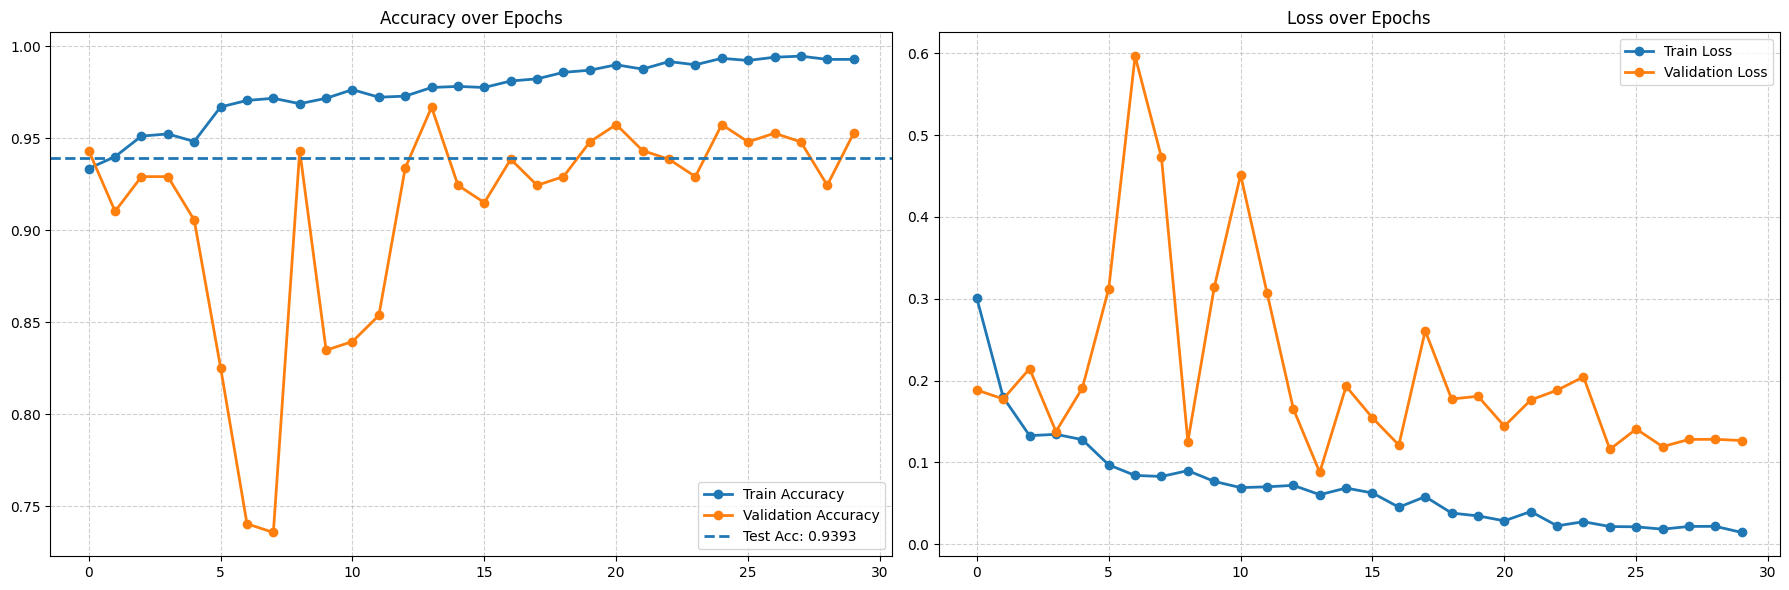

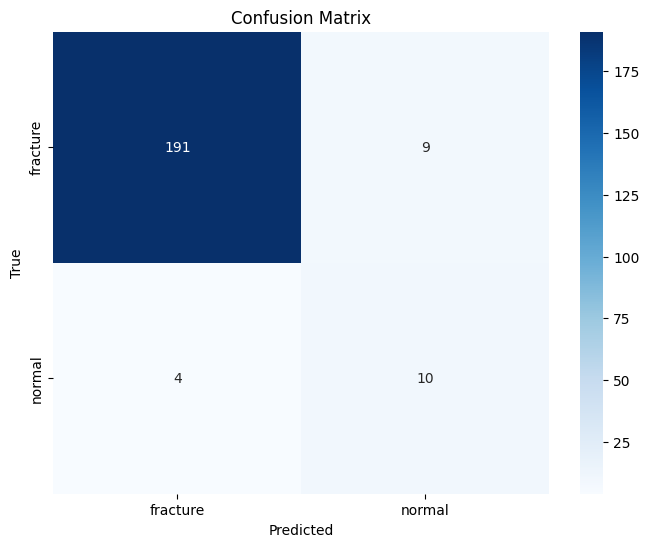

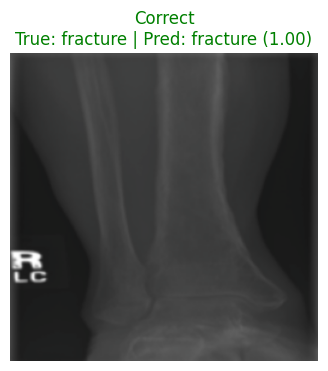

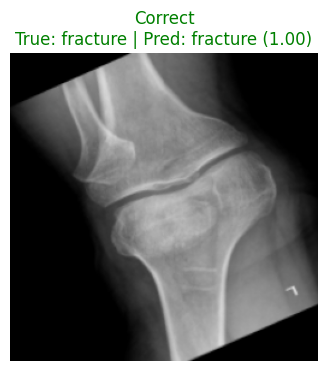

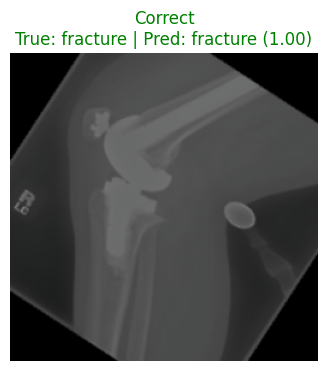

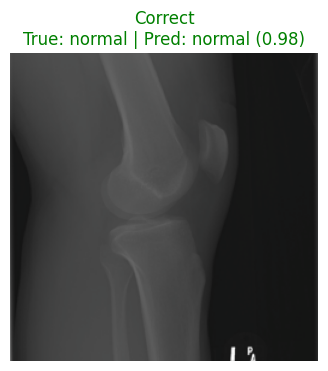

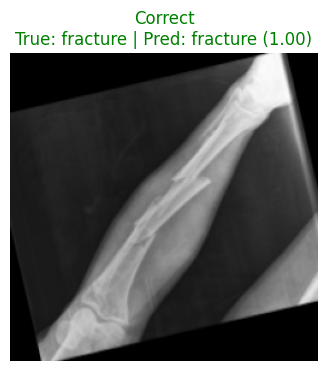

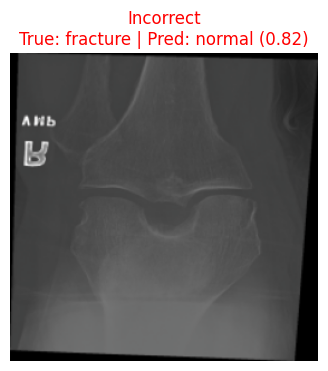

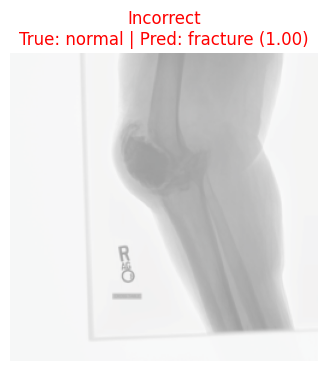

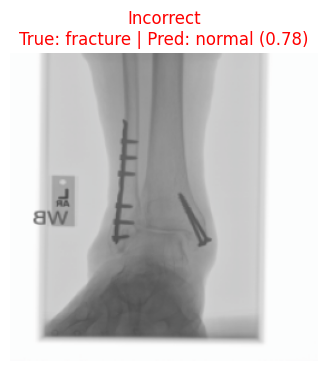

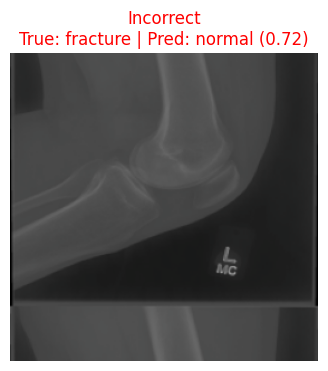

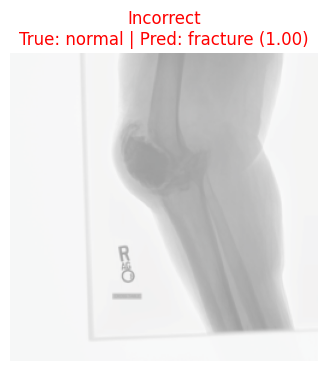

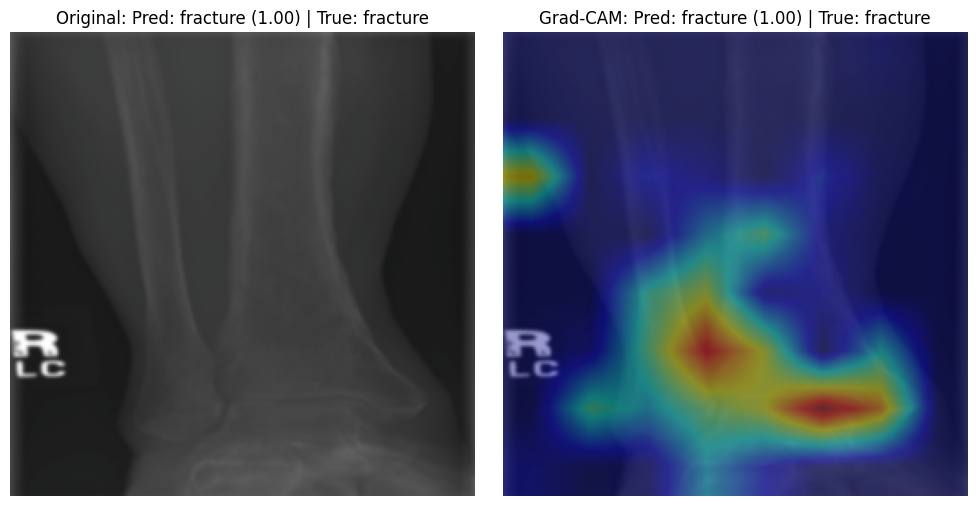

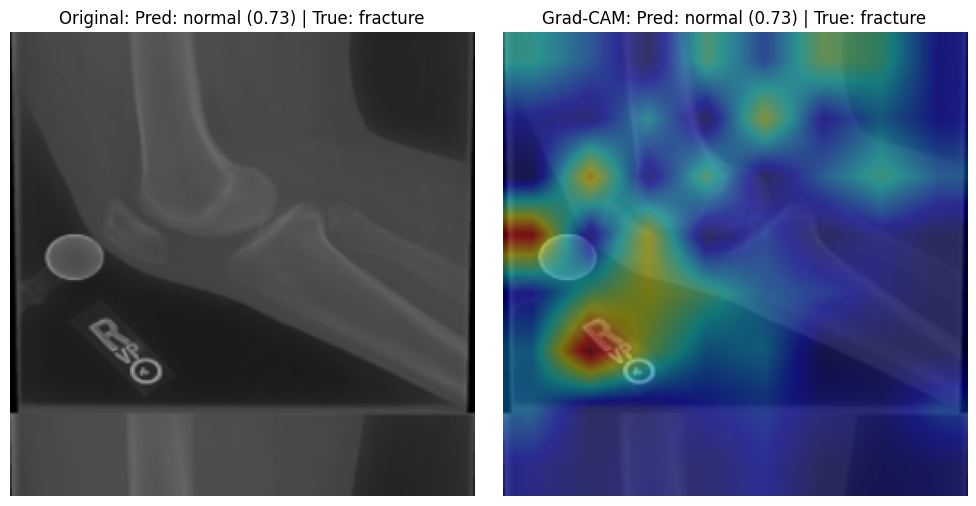

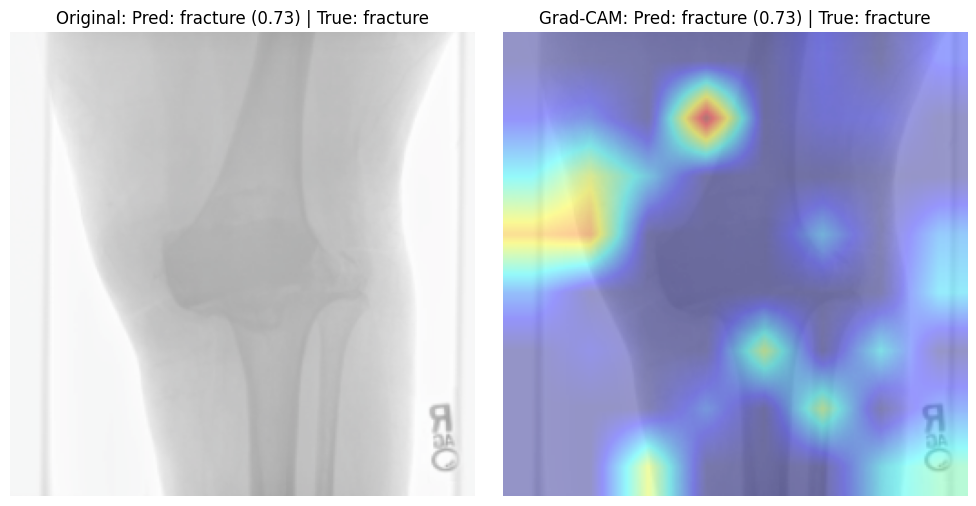

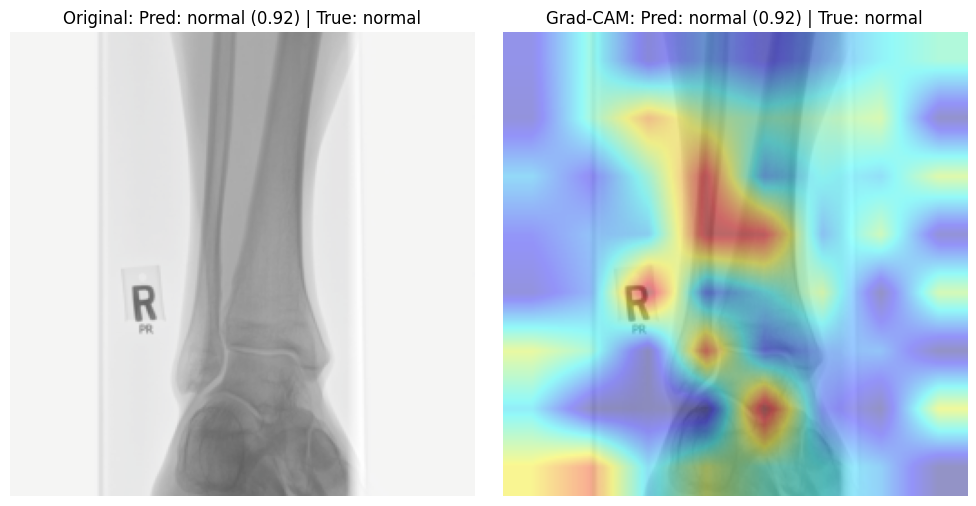

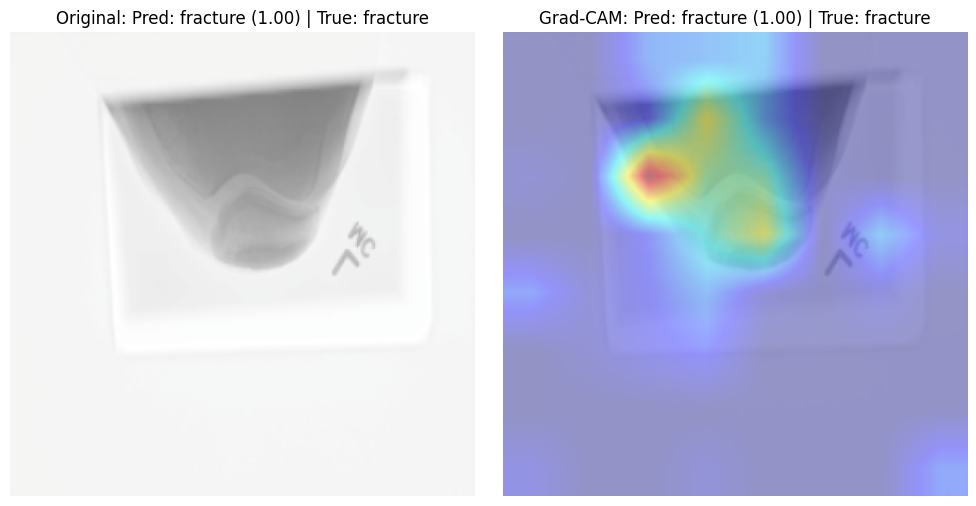

Validation: 100%|██████████| 107/107 [00:13<00:00,  7.77batch/s]


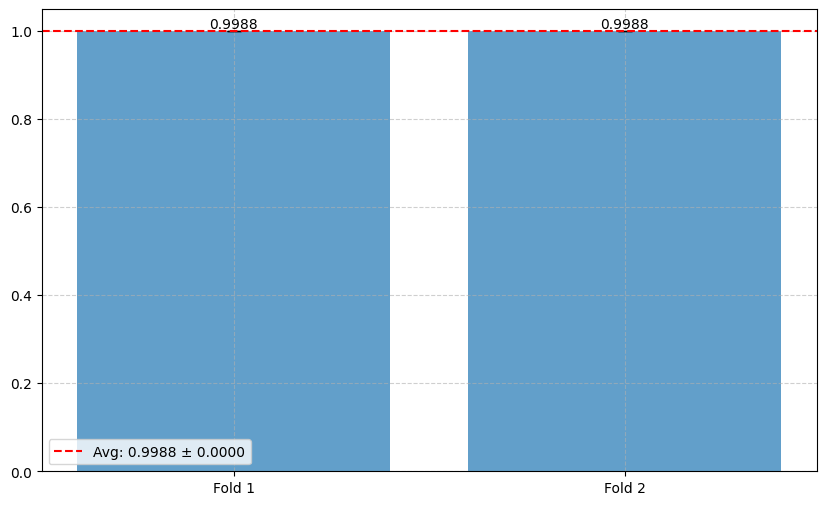

[I 2026-02-06 07:42:54,230] A new study created in memory with name: no-name-918aaa28-65d0-40c5-a7b4-6b3c455ac4e8
Validation: 100%|██████████| 27/27 [00:02<00:00, 10.31batch/s]
[I 2026-02-06 07:44:29,680] Trial 0 finished with value: 0.9481132075471698 and parameters: {'nhead': 8, 'dropout': 0.3111769821121171, 'lr': 0.0004137213427060492, 'weight_decay': 8.827458795474248e-05}. Best is trial 0 with value: 0.9481132075471698.
Validation: 100%|██████████| 27/27 [00:02<00:00,  9.24batch/s]
[I 2026-02-06 07:46:07,801] Trial 1 finished with value: 0.9433962264150944 and parameters: {'nhead': 4, 'dropout': 0.3116990618453215, 'lr': 0.0002266630662205625, 'weight_decay': 1.3143082180194872e-05}. Best is trial 0 with value: 0.9481132075471698.


In [ ]:
# CELL 12: Main Pipeline Execution

def main():
    """Main execution pipeline"""

    # 🚀 START
    stage("🚀 Bone Fracture Detection Pipeline", "End-to-end training, evaluation, and visualization")

    # =========================
    # Phase 1: Data Preparation
    # =========================
    stage("Phase 1: Data Preparation", "Load data, apply transforms, and build dataloaders", "#a5b4fc")

    data_path = DatasetManager.load_dataset(CFG.DATA_PATH)
    image_datasets = DatasetManager.create_dataset_splits(data_path, CFG.IMAGE_SIZE)
    dataloaders, dataset_sizes, class_names = DatasetManager.create_dataloaders(
        image_datasets, CFG.BATCH_SIZE
    )
    DatasetManager.prepare_metadata(image_datasets)

    card(
        f"✅ Data ready | "
        f"Train: {dataset_sizes['train']} | "
        f"Val: {dataset_sizes['val']} | "
        f"Test: {dataset_sizes['test']} | "
        f"Classes: {class_names}",
        "#34d399"
    )

    # =========================
    # Phase 2: Model Setup
    # =========================
    stage("Phase 2: Model Construction", "Initialize CNN-Transformer model", "#facc15")

    model = HybridModel(
        CFG.MODEL_NAME, CFG.NUM_CLASSES, CFG.D_MODEL,
        CFG.NHEAD, CFG.NUM_ENCODER_LAYERS,
        CFG.DIM_FEEDFORWARD, CFG.DROPOUT
    ).to(CFG.device)

    ModelUtils.initialize_weights(model)
    ModelUtils.freeze_backbone(model)

    card(f"✅ Model initialized on {CFG.device}", "#34d399")

    # =========================
    # Phase 3: Training
    # =========================
    stage("Phase 3: Training", "Fit the model on training data", "#fb7185")

    criterion = ModelUtils.get_loss_function()
    optimizer = ModelUtils.get_optimizer(model, CFG.LEARNING_RATE)
    scheduler = ModelUtils.get_lr_scheduler(optimizer, epochs=CFG.EPOCHS)

    history = dict(train_loss=[], train_acc=[], val_loss=[], val_acc=[])
    best_val_acc = 0.0

    for epoch in range(CFG.EPOCHS):
        card(f"🔄 Epoch {epoch+1}/{CFG.EPOCHS}", "#60a5fa")

        # 🔓 Unfreeze backbone halfway
        if epoch == CFG.EPOCHS // 2:
            card("🔓 Unfreezing backbone + LR decay", "#fde047")
            ModelUtils.unfreeze_backbone(model)
            optimizer = ModelUtils.get_optimizer(model, CFG.LEARNING_RATE * 0.1)
            scheduler = ModelUtils.get_lr_scheduler(
                optimizer, epochs=CFG.EPOCHS - epoch
            )

        train_loss, train_acc = TrainingUtils.train_one_epoch(
            model,
            dataloaders['train'],
            criterion,
            optimizer,
            CFG.device
        )

        val_loss, val_acc, _, _, _ = TrainingUtils.evaluate(
            model,
            dataloaders['val'],
            criterion,
            CFG.device,
            split="Validation"
        )

        scheduler.step()

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        card(
            f"📊 Train Acc: {train_acc:.4f} | "
            f"Val Acc: {val_acc:.4f} | "
            f"Train Loss: {train_loss:.4f} | "
            f"Val Loss: {val_loss:.4f}",
            "#22d3ee"
        )

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            ModelUtils.save_checkpoint(
                model, optimizer, epoch, val_acc,
                os.path.join(CFG.OUTPUT_DIR, "best_model.pth")
            )
            card(f"💾 New best model saved (Val Acc: {val_acc:.4f})", "#4ade80")

    # =========================
    # Phase 4: Evaluation
    # =========================
    stage("Phase 4: Evaluation", "Run validation and testing metrics", "#c084fc")

    best_model = HybridModel(
        CFG.MODEL_NAME, CFG.NUM_CLASSES, CFG.D_MODEL,
        CFG.NHEAD, CFG.NUM_ENCODER_LAYERS,
        CFG.DIM_FEEDFORWARD, CFG.DROPOUT
    ).to(CFG.device)

    best_model = ModelUtils.load_best_model(
        best_model, os.path.join(CFG.OUTPUT_DIR, "best_model.pth")
    )

    test_loss, test_acc, labels, preds, probs = TrainingUtils.test_inference(
        best_model, dataloaders['test'], criterion, CFG.device
    )

    metrics = MetricsAndVisualization.compute_metrics(labels, preds, probs)

    card(
        f"✅ Test Results | "
        f"Acc: {metrics['accuracy']:.4f} | "
        f"Prec: {metrics['precision']:.4f} | "
        f"Recall: {metrics['recall']:.4f} | "
        f"F1: {metrics['f1']:.4f} | "
        f"AUC: {metrics['auc']:.4f}",
        "#34d399"
    )

    stage("Training Curves", "Accuracy and loss trends", "#60a5fa")
    MetricsAndVisualization.plot_curves(history, test_acc, metrics['auc'])

    stage("Confusion Matrix", "Classification results on test set", "#93c5fd")
    MetricsAndVisualization.plot_confusion_matrix(labels, preds, class_names)

    stage("Prediction Samples", "Correct vs incorrect examples", "#fda4af")
    MetricsAndVisualization.analyze_predictions(
        best_model, dataloaders['test'], class_names, CFG.device
    )

    # =========================
    # Phase 4.5: Grad-CAM
    # =========================
    stage("Phase 4.5: Grad-CAM", "Localize fracture regions", "#fb7185")
    GradCAMUtils.generate_and_save_gradcam_samples(
        best_model, dataloaders['test'],
        class_names, CFG.device, num_samples=5
    )

    # =========================
    # Phase 4.75: Weak Segmentation
    # =========================
    if CFG.RUN_WEAK_SEG:
        stage("Phase 4.75: Weak Segmentation", "Train a weakly supervised mask head", "#38bdf8")
        seg_model, seg_history = train_weak_segmentation(
            best_model, dataloaders, class_names
        )
        stage("Weak Segmentation Loss", "Pseudo-mask training curve", "#67e8f9")
        plot_segmentation_loss(seg_history)
        stage("Weak Segmentation Samples", "Overlay predicted masks", "#22d3ee")
        visualize_segmentation_sample(seg_model, dataloaders['test'], class_names)

    # =========================
    # Phase 5: Robustness
    # =========================
    stage("Phase 5: Robustness & Optimization", "K-folds, hyperparameter tuning, calibration", "#22d3ee")

    folds = AdvancedTechniques.k_fold_cross_validation(
        CFG.DATA_PATH, CFG.IMAGE_SIZE, CFG.BATCH_SIZE
    )
    AdvancedTechniques.plot_kfold_results(folds)

    best_params = AdvancedTechniques.hyperparameter_tuning(
        dataloaders['train'], dataloaders['val']
    )

    card(f"⚙️ Best Hyperparameters: {best_params}", "#a7f3d0")

    ece = AdvancedTechniques.evaluate_model_calibration(
        best_model, dataloaders['test'], CFG.device
    )
    card(f"📐 Calibration ECE: {ece:.4f}", "#fda4af")

    card("🎉 Pipeline completed successfully!", "#4ade80")


if __name__ == "__main__":
    main()